In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os

In [2]:
def threshold(imgName, blockSize):   
    img = cv2.imread(imgName)
    
    # convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # blur and adaptive thresholding
    # source: https://docs.opencv.org/master/d7/d4d/tutorial_py_thresholding.html
    blur = cv2.GaussianBlur(gray,(5,5),0)
    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, blockSize, -2)

    # Remove noise by opening
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN,kernel, iterations=2)
    
    # Check if opening was too much
    numWhitePixels = cv2.countNonZero(opening) # number of foreground pixels
    totalPixels = img.size / 3 # not sure why it has to be divided by 3
    if numWhitePixels / totalPixels < 0.3:
        # if opening resulted in less than 30% foreground, decrease number of opening iterations
        opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN,kernel, iterations=1)
    
    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform, 1.5, 255, 0)
    sure_fg = np.uint8(sure_fg)

    # Label and count
    # source: https://medium.com/analytics-vidhya/images-processing-segmentation-and-objects-counting-in-an-image-with-python-and-opencv-216cd38aca8e
    output = cv2.connectedComponentsWithStats(sure_fg, 8, cv2.CV_32S)
    labels = output[1]
    count = output[0] - 1 # background doesn't count as a scale
    label_hue = np.uint8(179 * labels / np.max(labels))
    blank_ch = 255 * np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
    labeled_img[label_hue == 0] = 0
    
    stats = output[2]
    areas = []
    ratios = []
    for i in range(1, count + 1): # start at 1 instead of 0 because don't want to count background as a scale
        scaleArea = stats[i, cv2.CC_STAT_AREA]
        areas.append(scaleArea)
        boxArea = stats[i, cv2.CC_STAT_WIDTH] * stats[i, cv2.CC_STAT_HEIGHT]
        ratios.append(scaleArea / boxArea)
    avgRoundness = sum(ratios) / len(ratios)
    #avgSize = sum(areas) / len(areas)
    #variance = sum([((x - avgSize) ** 2) for x in areas]) / len(areas)
    #stdDev = variance ** 0.5
    
    #displayTests(gray, imgName, thresh, opening, sure_fg, labeled_img, count)
    
    return (avgRoundness, count, labeled_img)

In [12]:
# tries thresholding with various blockSizes and chooses the one with the most "round" scales
def countScales(imgName):
    maxRoundness = 0
    for blockSize in [15, 25, 35, 65, 75]: # blocksize must be odd number
        roundness, count, labeled_img = threshold(imgName, blockSize)
        if roundness > maxRoundness:
            maxRoundness = roundness
            bestCount = count
            bestSize = blockSize
            bestImage = labeled_img
    displayFinal(imgName, bestImage, bestCount, bestSize)

In [13]:
# display final results
def displayFinal(imgName, labeled_img, count, blockSize):
    
    img = cv2.imread(imgName)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    plt.subplot(1, 2, 1), plt.imshow(gray, 'gray')
    plt.title(imgName[12:])
    
    plt.subplot(1, 2, 2), plt.imshow(labeled_img, 'gray')
    plt.title('Count: ' + str(count) + ', Blocksize:' + str(blockSize))
    
    plt.show()

In [14]:
# ignore this - not currently being used
def displayTests(orig, imgName, thresh, opening, sure_fg, labeled_img, count):
    
    plt.subplot(1, 5, 1), plt.imshow(orig, 'gray')
    plt.title(imgName[12:])
    
    plt.subplot(1, 5, 2), plt.imshow(thresh, 'gray')
    plt.title('Threshold')
    
    plt.subplot(1, 5, 3), plt.imshow(opening, 'gray')
    plt.title('Opening')
    
    plt.subplot(1, 5, 4), plt.imshow(sure_fg, 'gray')
    plt.title('Sure fg')
    
    plt.subplot(1, 5, 5), plt.imshow(labeled_img, 'gray')
    plt.title('Count: ' + str(count))
    plt.show()

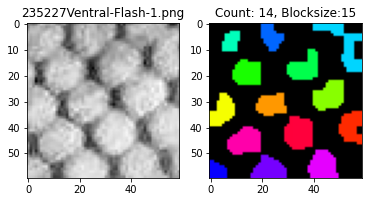

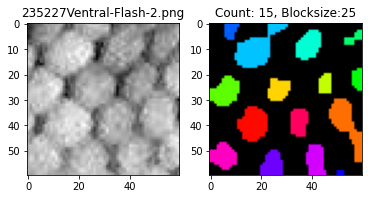

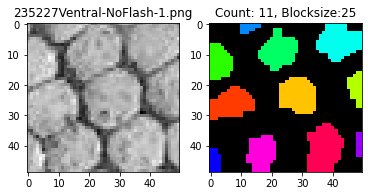

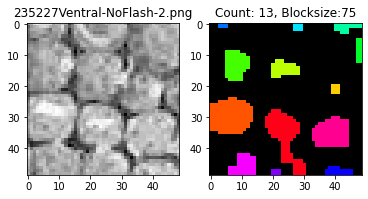

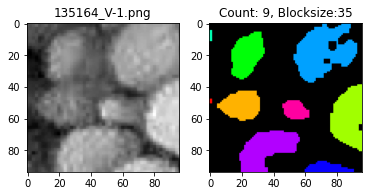

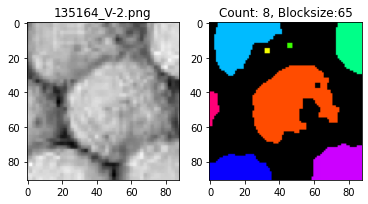

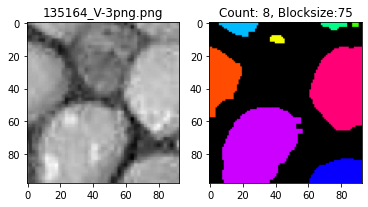

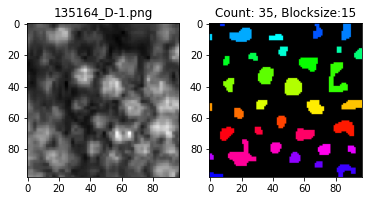

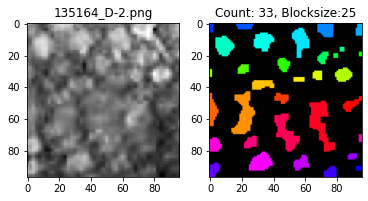

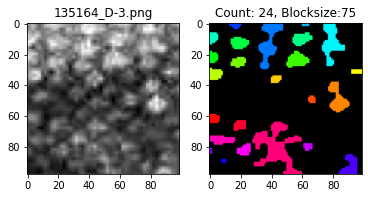

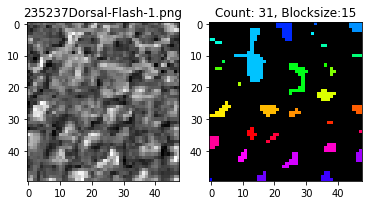

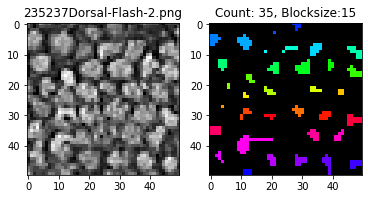

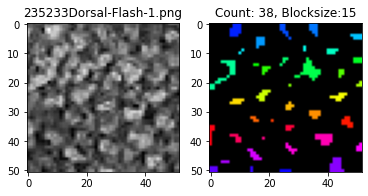

In [15]:
countScales('More_images/235227Ventral-Flash-1.png')
countScales('More_images/235227Ventral-Flash-2.png')

countScales('More_images/235227Ventral-NoFlash-1.png')
countScales('More_images/235227Ventral-NoFlash-2.png')

countScales('More_images/135164_V-1.png')
countScales('More_images/135164_V-2.png')
countScales('More_images/135164_V-3png.png')

countScales('More_images/135164_D-1.png')
countScales('More_images/135164_D-2.png')
countScales('More_images/135164_D-3.png')

countScales('More_images/235237Dorsal-Flash-1.png')
countScales('More_images/235237Dorsal-Flash-2.png')

countScales('More_images/235233Dorsal-Flash-1.png')

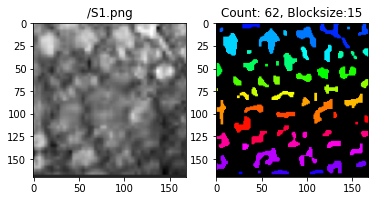

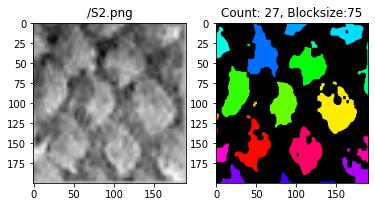

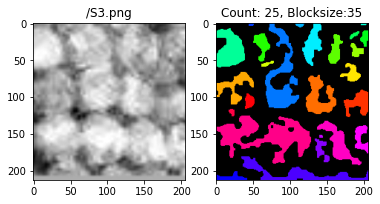

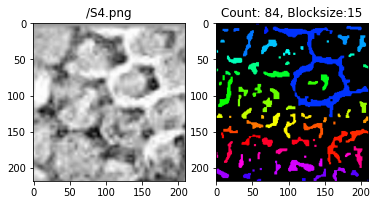

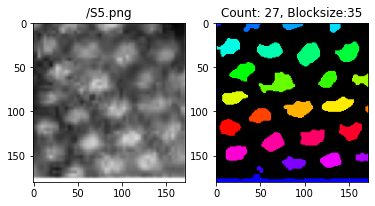

In [7]:
countScales('Scale_images/S1.png')
countScales('Scale_images/S2.png')
countScales('Scale_images/S3.png')
countScales('Scale_images/S4.png')
countScales('Scale_images/S5.png')

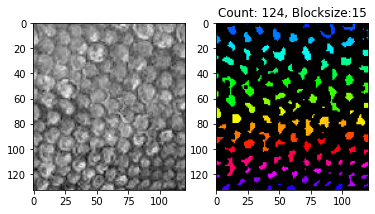

In [8]:
countScales('no_grid.png')

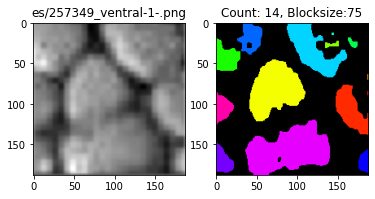

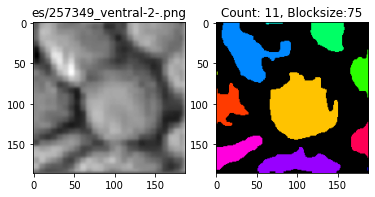

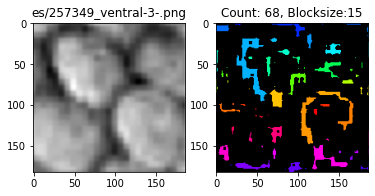

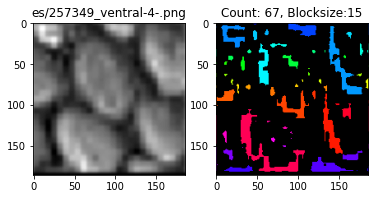

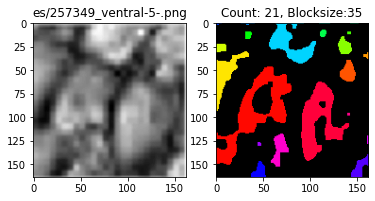

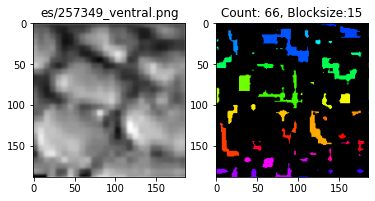

In [9]:
countScales('grouped_images/257349_ventral-1-.png')
countScales('grouped_images/257349_ventral-2-.png')

countScales('grouped_images/257349_ventral-3-.png')
countScales('grouped_images/257349_ventral-4-.png')

countScales('grouped_images/257349_ventral-5-.png')
countScales('grouped_images/257349_ventral.png')
